In [1]:
import sys
sys.path.insert(1, '../')


In [2]:
import importlib
import medical_explainer
importlib.reload(medical_explainer)


<module 'medical_explainer' from '/Users/llja0112/repos/Uni-ACS/mimiciv_sepsis_mortality/../medical_explainer.py'>

In [3]:
import pandas as pd
data = pd.read_csv('mimiciv_sepsis.csv').drop(['testtrain', 'hadm_id'], axis=1)

data['gender'] = data['gender'].apply(lambda x: 1 if x == 'M' else 0)

data = pd.concat([data, pd.get_dummies(data['marital_status'], prefix='marital_status')], axis=1)
data = data.drop(['marital_status'], axis=1)

data = pd.concat([data, pd.get_dummies(data['ethnicity'], prefix='ethnicity')], axis=1)
data = data.drop(['ethnicity'], axis=1)

data = pd.concat([data, pd.get_dummies(data['insurance'], prefix='insurance')], axis=1)
data = data.drop(['insurance'], axis=1)

data = pd.concat([data, pd.get_dummies(data['ed_medgp_antibiotic_hrgp'], prefix='antibiotic')], axis=1)
data = data.drop(['ed_medgp_antibiotic_hrgp'], axis=1)

In [4]:
from sklearn.model_selection import train_test_split

seed = 7

X = data.drop(['icu_adm_flag', 'hosdeath_flag'], axis=1)
y = data['hosdeath_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed)


In [5]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X_train)

X_train = pd.DataFrame(imp.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(imp.transform(X_test), columns=X.columns)

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators=260, max_depth=5, random_state=seed)
clf.fit(X_train, y_train)

roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, clf.predict_proba(X_test)[:, 1])
print("Average Precision: " + str(average_precision))

accuracy = accuracy_score(y_test, clf.predict(X_test))
print("Accuracy: " + str(accuracy))

ROC AUC: 0.9005214042364095
Average Precision: 0.45050732164899465
Accuracy: 0.9319462505418292


| Step 1  ==> Calibrating model


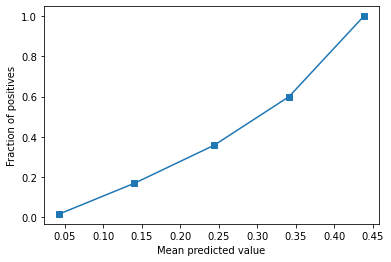

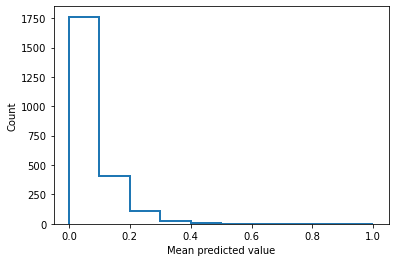

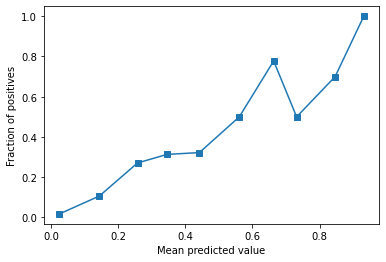

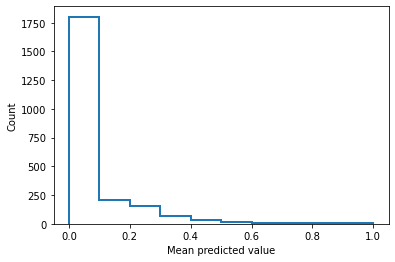

ROC AUC: 0.9005214042364095
Average Precision: 0.45050732164899465
Accuracy: 0.9319462505418292
ROC AUC: 0.9029225299955562
Average Precision: 0.44121216978100386
Accuracy: 0.9380147377546597

| Step 2 ==> Calculate SHAP values

| Step 3 ==> Fit clinical score calculator
Novel fitting


Probability threshold: 0.1
Score threshold: 3374.0

Probability threshold: 0.5
Score threshold: 8826.0

Probability threshold: 0.9
Score threshold: 8826.0



In [7]:
explainer = medical_explainer.explainer(
    clf, X_train, y_train, X_test, y_test)

explainer.fit(10, shap_method='tree', method='novel', calculator_threshold=0.0001)

In [8]:
explainer.shap_array_list

[[-0.13665205877146147, 0.5620089042320889],
 [-0.06670748570249256, 0.20550199110745324],
 [-0.06779012543665819, 0.1082114704173269],
 [-0.060318444400703254, 0.13012492768308492],
 [0.017265187659029554, -0.0532047219314704, 0.15062498700056978],
 [-0.06005533752927854, 0.10893632725595043],
 [0.1544315593248754, -0.04947054472561545, 0.06015187422385044],
 [-0.030264532683766558, 0.3354714585280849],
 [0.11211963258656933, -0.030509024220992775],
 [0.0002880398136120757, -0.031842944115496305, 0.08810648561914404]]

In [9]:
explainer.score_array_list

[array([-474., 1951.]),
 array([-232.,  713.]),
 array([-235.,  376.]),
 array([-209.,  452.]),
 array([  60., -185.,  523.]),
 array([-208.,  378.]),
 array([ 536., -172.,  209.]),
 array([-105., 1165.]),
 array([ 389., -106.]),
 array([   1., -111.,  306.])]

In [10]:
explainer.variables

array(['time2bg_24hr_flag', 'edvital_resprate_median',
       'charlson_comorbidity_index', 'fbc24hr_rdw_first',
       'edvital_resprate_max', 'chem24hr_bun_first', 'edvital_sbp_min',
       'metastatic_solid_tumor', 'edvital_sbp_median',
       'fbc24hr_wbc_first'], dtype=object)

In [11]:
explainer.breakpoints_list

[[0.0, 0.20180366101634944, 1.0],
 [9.5, 20.647605704597833, 62.0],
 [0.0, 6.605599097458832, 20.0],
 [11.1, 15.659532314327866, 29.2],
 [12.0, 14.484592011682558, 24.677487898639427, 165.0],
 [2.0, 26.11931564756045, 243.0],
 [4.0, 95.51406138030738, 187.95885692996555, 202.0],
 [0.0, 0.09123358269060851, 1.0],
 [10.0, 105.73403747104788, 212.0],
 [0.1, 4.372458883935443, 13.575757195958653, 216.3]]

In [12]:
scores,probs,predictions = explainer.predict_calculator(X_test, 1)

In [13]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

roc_auc = roc_auc_score(y_test, probs)
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, probs)
print("Average Precision: " + str(average_precision))

# accuracy = accuracy_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: " + str(accuracy))

# print(confusion_matrix(y_test, predictions))
print(confusion_matrix(y_test, predictions))


ROC AUC: 0.8615849503777218
Average Precision: 0.3295425752908808
Accuracy: 0.9328131772865192
[[2149    1]
 [ 154    3]]


In [14]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


In [15]:
y_test = y_test.reset_index(drop=True)

In [16]:
from sklearn.utils import resample

auroc_array = []
auprc_array = []
accuracy_array = []

for i in range(50):
    X_test_bs = resample(X_test, n_samples=200, replace=False, stratify=y_test,
             random_state=i)
    y_test_bs = y_test[X_test_bs.index]

    scores,probs,predictions = explainer.predict_calculator(X_test_bs, 1)
    auroc = roc_auc_score(y_test_bs, probs)
    auprc = average_precision_score(y_test_bs, probs)
    accuracy = accuracy_score(y_test_bs, predictions)
    
    auroc_array.append(auroc)
    auprc_array.append(auprc)
    accuracy_array.append(accuracy)
    

print(mean_confidence_interval(auroc_array))
print(mean_confidence_interval(auprc_array))
print(mean_confidence_interval(accuracy_array))

(0.8618394777265747, 0.8484740949519542, 0.8752048605011951)
(0.3726988267130696, 0.33926775103153817, 0.406129902394601)
(0.9307, 0.9298875016494734, 0.9315124983505265)
